<a href="https://colab.research.google.com/github/saurabh423/Yes-Bank-Stock-Closing-Price-Prediction/blob/main/Capstone_Project_2_Yes_Bank_Stock_Closing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

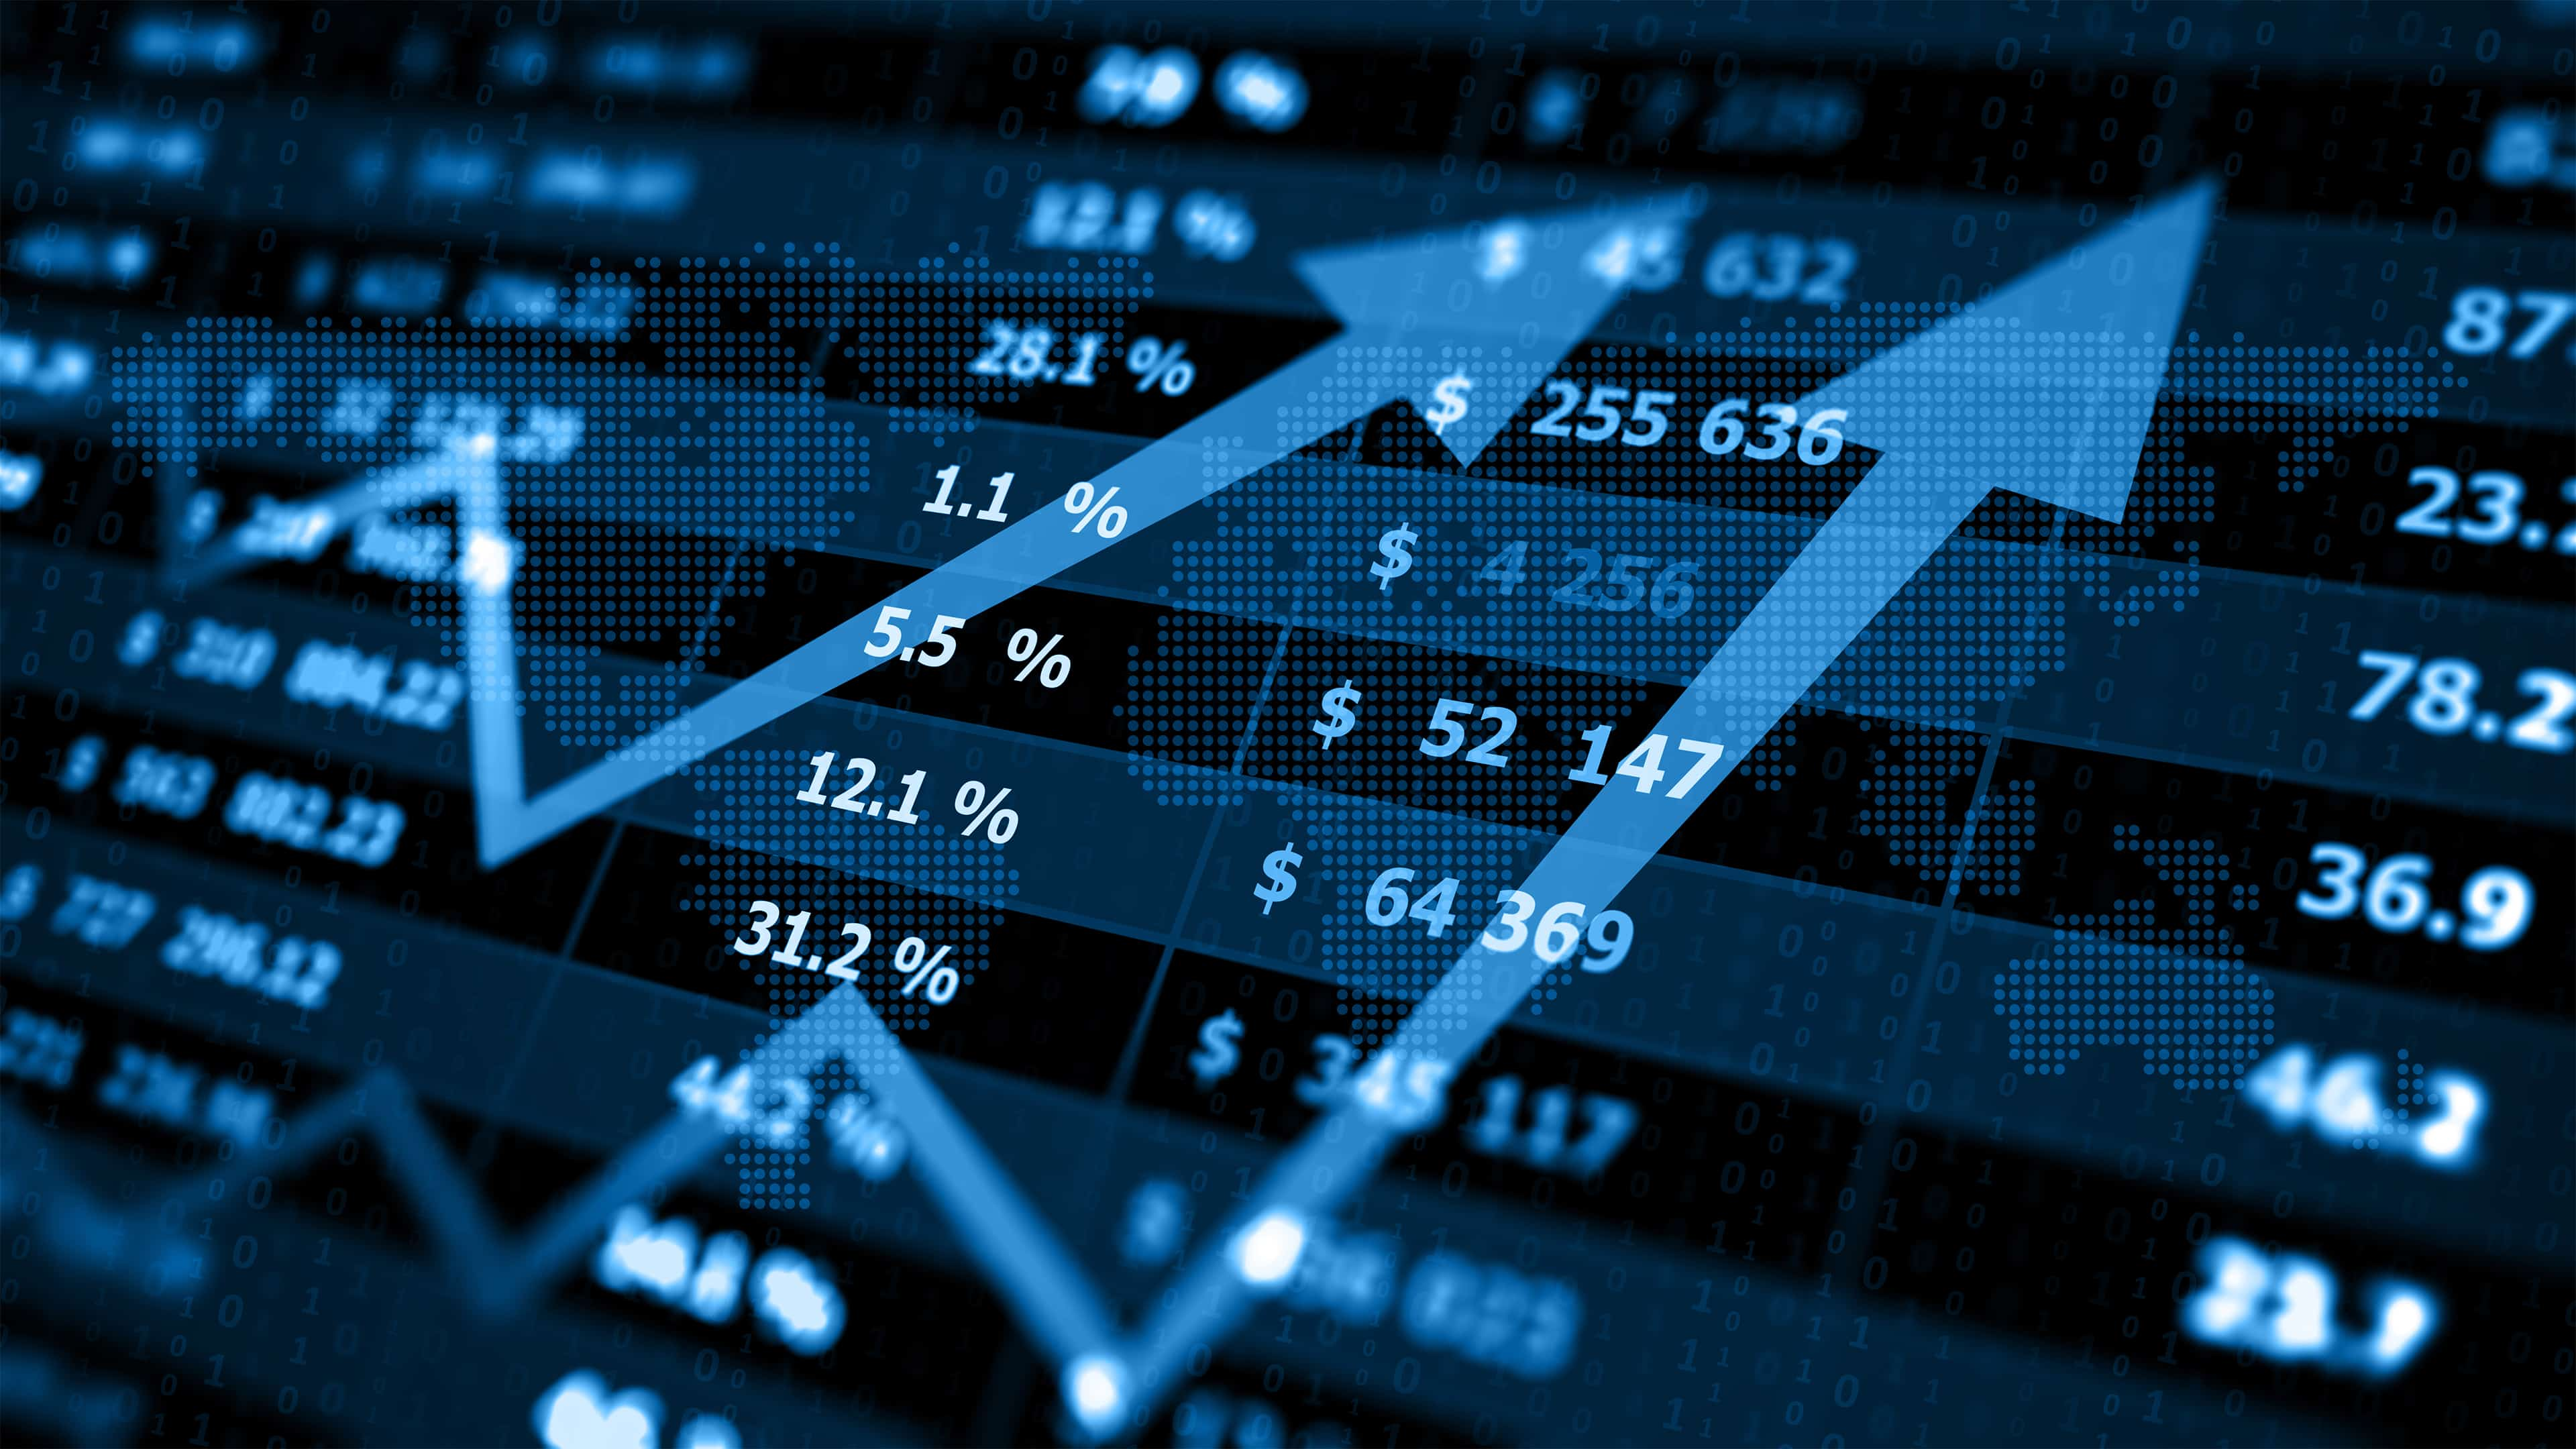

# <b> <u>Problem Statement</u></b>



## Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.

##**What is stock?**

A Stock or share (also known as a company’s “equity”) is a financial instrument that represents ownership in a company.

Since, we've the **YES BANK** Stock price dataset which has the monthly stock prices of the bank since its inception. 
It contains the following features:

* **Date:** It denotes date of investment done (in our case we have month and year).
* **Open:** Open means the price at which a stock started trading when the opening bell rang.
* **High:**  High refer to the maximum prices in a given time period.
* **Low:**  Low refer to the minimum prices in a given time period.
* **Close:** Close refers to the price of an individual stock when the stock exchange closed for the day.

# **In this project, we will be solving this problem Using Auto-ARIMA and Facebook FbProphet than we'll compare their performances.**



# What is FBProphet?

**Prophet, or “Facebook Prophet,”** is an open-source library for univariate (one variable) time series forecasting developed by **Facebook**.

**FBProphet** uses time as a regressor and tries to fit several linear and nonlinear function of time as components. By default, FBProphet will fit the data using a linear model but it can be changed to the nonlinear model (logistics growth) from its arguments.

# What is Auto-ARIMA?

Before training simple **ARIMA model** we have to figure out **p(AR), q(MA), d(Back Timeshift)** which is not as easy as fine-tuning other machine learning models and also we have to **reduce stationarity** and get those values which so time-consuming as well as boring.

**Auto-ARIMA** uses brute force and tries different combinations of p, q, and d and then returns the best model after evaluation. It uses mean squared error to evaluate the best model. It also uses Akaike Information Criteria (AIC) and Bayesian information criterion (BIC) which are statistical measures of goodness of fit and the simplicity of the model.

**First, we import required libraries:**

**Pmdarima** is a statistical library designed to fill the void in Python's time series analysis capabilities. 

In [1]:
# Installing 'pmdarima'
!pip install pmdarima

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

# **Reading the data**

The Dataset has Opening, Highest, Lowest and the Closing Prices of the Stock in every month. For this analysis,we select only Closing Stock Prices.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Almabetter/Module 4: Machine Learning/Capstone Project 2/dat/data_YesBank_StockPrices.csv", usecols=["Date", "Close"])

In [4]:
df.head()

,Date,Close
0,Jul-05,12.46
1,Aug-05,13.42
2,Sep-05,13.30
3,Oct-05,12.99
4,Nov-05,13.41


In [5]:
df.tail()

,Date,Close
180,Jul-20,11.95
181,Aug-20,14.37
182,Sep-20,13.15
183,Oct-20,12.42
184,Nov-20,14.67


# **Preparing the Time Series Data and Basic EDA**

The Given Date in data is of format MMM-YY is converted to proper date of YYYY-MM-DD.

Since, **Date** column has dtype as object we've to convert it into datetime format.

In [ ]:
# Importing datetime 
from datetime import datetime
# converting date to proper format of date
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: datetime.strptime(x, '%b-%y')))

In [7]:
# setting date column as an index
df.set_index('Date',inplace=True)
df.index.freq = 'MS'

In [8]:
# First 5 values
df.head()

,Close
Date,
2005-07-01,12.46
2005-08-01,13.42
2005-09-01,13.30
2005-10-01,12.99
2005-11-01,13.41


In [9]:
# Cheking for missing values
df.isnull().sum()

Close    0
dtype: int64

 The next single-line code will visualize the location of missing values.

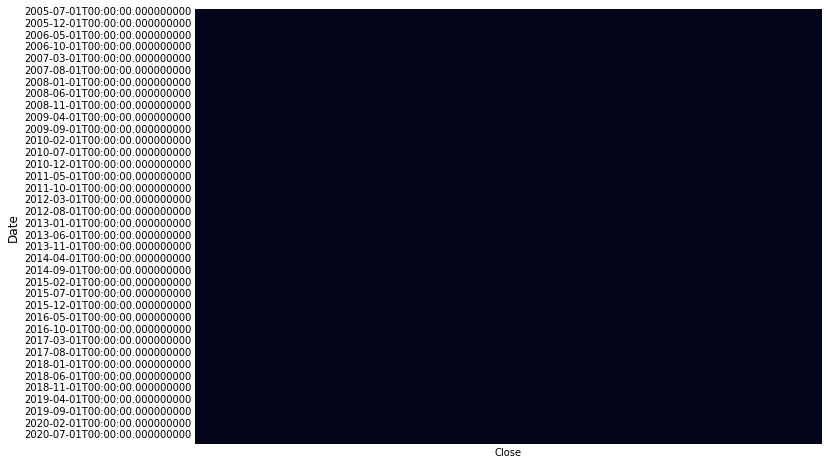

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.isnull(), cbar=False, ax=ax)

As seen above we don't have any missing values and we're good to go....

# **Visualising the data**

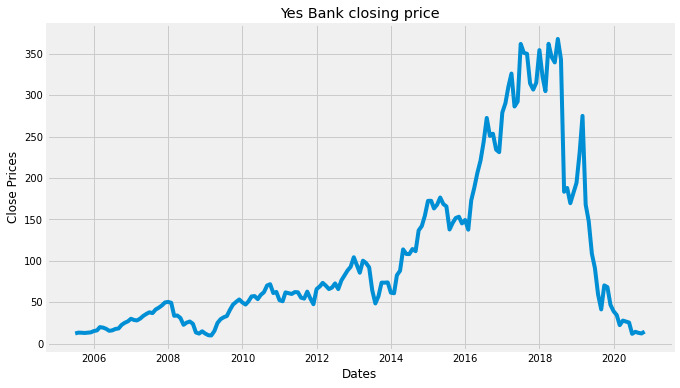

In [11]:
#plotting close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Yes Bank closing price')
plt.show()

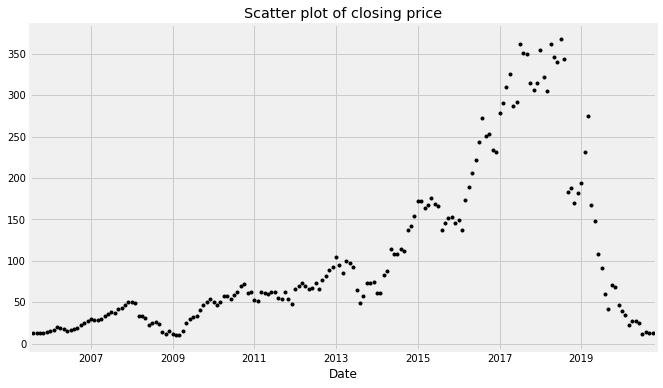

In [12]:
# Plotting Scatter plot of close price
plt.figure(figsize=(10,6))
df['Close'].plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

As seen in above plot the trend is increasing from 2009 to 2018 but after that the trend decreases. This is because of the fraud case of involving Rana Kapoor.

In [13]:
# Data distribution of closing price
df.describe()

,Close
count,185.000000
mean,105.204703
std,98.583153
min,9.980000
25%,33.450000
50%,62.540000
75%,153.300000
max,367.900000


**Now, we need to check if a series is stationary or not because time series analysis only works with stationary data.**

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

**So let's check for stationarity:**

In [14]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determining the rolling statistics
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std()
    
    # Ploting rolling statistics:
    rcParams['figure.figsize'] = 10, 6
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Close'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    if output[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary. ")


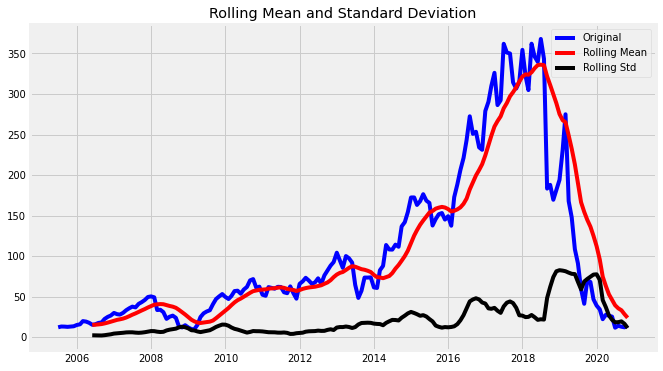

Results of dickey fuller test
Test Statistics                 -1.906409
p-value                          0.329052
No. of lags used                14.000000
Number of observations used    170.000000
critical value (1%)             -3.469413
critical value (5%)             -2.878696
critical value (10%)            -2.575917
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary. 


In [15]:
test_stationarity(df)


We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

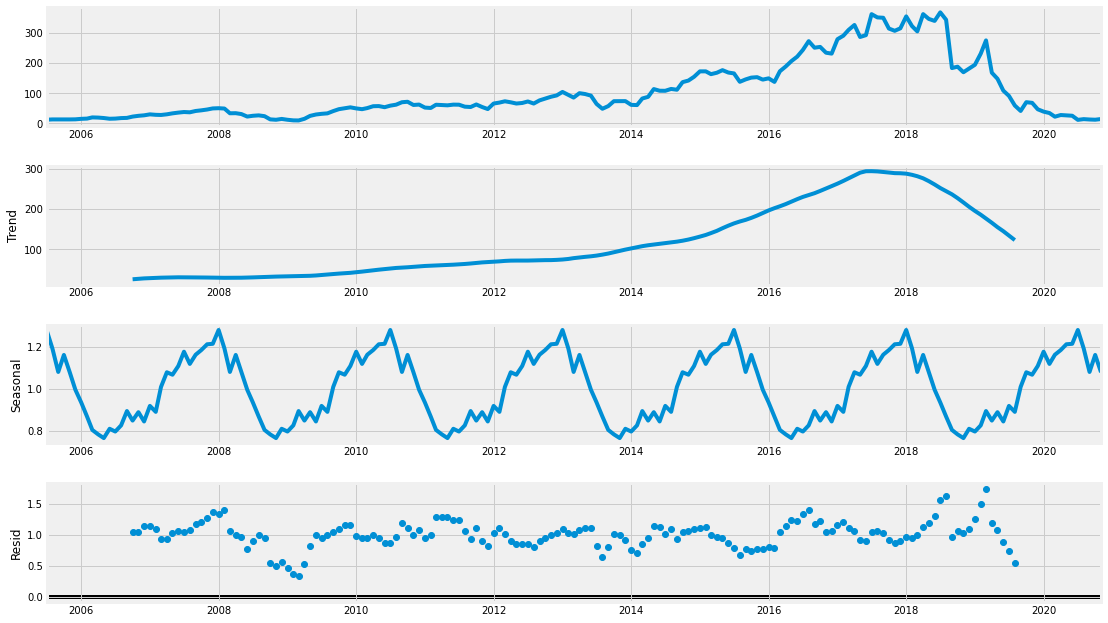

In [16]:
result = seasonal_decompose(df, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Now, we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series.

 A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


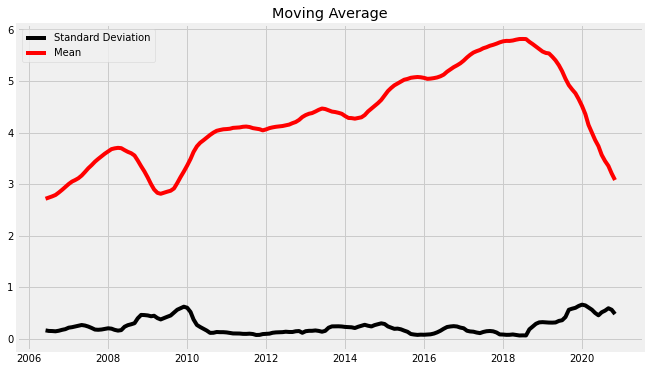

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

As we can see above the standard deviation follows the straight line.

# Building Auto-ARIMA model

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data.

 So let us split the data into training and test set and visualize it.

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.


In [18]:
# Checking size
df_log.shape

(185, 1)

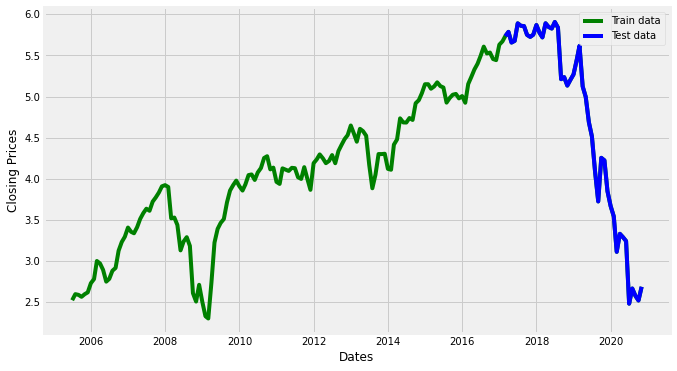

In [19]:
#split data into train and training set
train_data, test_data = df_log[0:140], df_log[140:185]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Now, Its time to choose parameters **p,q,d** for ARIMA model. 

Here, we use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

**Auto ARIMA:** Automatically discover the optimal order for an ARIMA model.

*  The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. 

*  The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges.

* If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [20]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality inculded
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=795.927, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-151.867, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-152.437, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-151.079, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-151.162, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-151.036, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-148.460, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-153.179, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-152.794, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-150.346, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-151.949, Ti

So the Auto ARIMA model provided the value of **p,d, and q as 2,0 and 1** respectively.


Now, let’s see the **residual plots from Auto-ARIMA.**

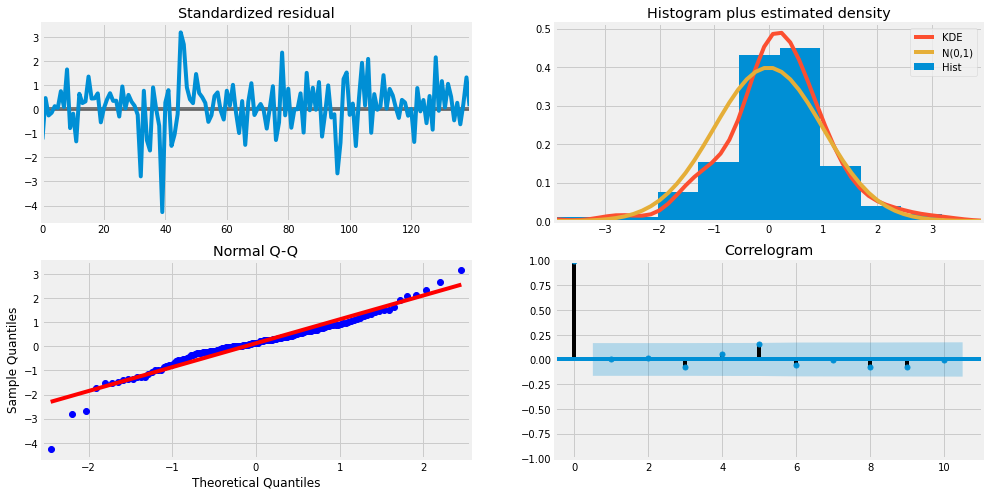

In [21]:
# Plotting residual plots
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Here,

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [22]:
model = ARIMA(train_data, order=(2, 0, 1))  
fitted = model.fit(disp=-1)
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  140
Model:                     ARMA(2, 1)   Log Likelihood                  81.589
Method:                       css-mle   S.D. of innovations              0.133
Date:                Thu, 08 Jul 2021   AIC                           -153.179
Time:                        07:36:32   BIC                           -138.471
Sample:                    07-01-2005   HQIC                          -147.202
                         - 02-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0716      0.985      4.132      0.000       2.140       6.003
ar.L1.Close     0.4875      0.173      2.821      0.005       0.149       0.826
ar.L2.Close     0.5002      0.173      2.894    

# Forcasting the moodel:

Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

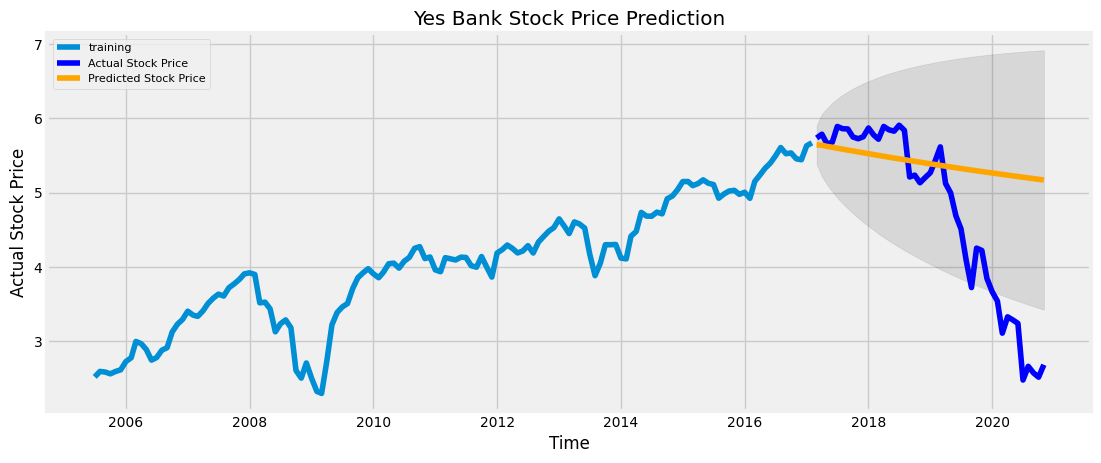

In [23]:
# Forecast
fc, se, conf = fitted.forecast(45, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Yes Bank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Performance matrics

In [24]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 1.4775937475155925
MAE: 0.8568946782548862
RMSE: 1.215563140077714


In [25]:
# Calculating Mean absolute percentage error
fc=fc.reshape(45,1)
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MAPE: Close    0.255146
dtype: float64


In [26]:
# Accuracy
errors = abs(fc - test_data)
mape = 100 * (errors / test_data)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: Close    74.49
dtype: float64 %.


Around 25.5% MAPE(Mean Absolute Percentage Error) implies the model is about 74.5% accurate in predicting the test set observations.



---



---



Now, let's see the forcasting the data using **Fbprophet.**

# **Forecasting Timeseries Data Using Facebook FbProphet**

Prophet is Facebook's library for time series forecasting.

Prophet follows the sklearn model API.


Here, we create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: **ds and y**

 The **ds (datestamp)** column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The **y** column must be numeric, and represents the measurement we wish to forecast.

**Steps Required With FbProphet:**
* Installing fbprophet
* Data Preprocessing With Time Seires
* Model Fitting
* Obtaining The Forecasts
* Plotting The Forecasts
* Cross Validation
* Computing Performance Metrics
* Visualize the Performance MEtrics
* Conclusions

In [27]:
import fbprophet

# **Data Preprocessing**

In [28]:
df.reset_index('Date',inplace=True)

In [29]:
# Rename the column name
df.columns=["ds","y"]

**Prophet always expects two columns in the input DataFrame:** **ds and y** . The **ds** column represents the date from your data, and needs to be either date or datetime data type.

 The **y** column represents the value we are looking to forecast, and must be of numeric data type.

In [30]:
df.head()

,ds,y
0,2005-07-01,12.46
1,2005-08-01,13.42
2,2005-09-01,13.30
3,2005-10-01,12.99
4,2005-11-01,13.41


**Note:** while building the **fbprophet** model we don't need to care about stationarity of the series **fbprophet** will take care of it.

# **Model Fitting:**

In [31]:
# Importing FBPROPHET
from fbprophet import Prophet

In [32]:
# Inbuilt fuctions present in fbprophet
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_col

In [33]:
df.head()

,ds,y
0,2005-07-01,12.46
1,2005-08-01,13.42
2,2005-09-01,13.30
3,2005-10-01,12.99
4,2005-11-01,13.41


Now, 
* we fit the model by instantiating a new Prophet object.

* Then we call its fit method and pass in the historical dataframe.

* Then predictions are made on a dataframe with a column **ds** containing the dates for which a prediction is to be made. We can get a suitable dataframe that extends into the future a specified number of days using the helper method **Prophet.make_future_dataframe.**

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long.

It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python)

Below we've added the seasonality as **monthly** 

In [34]:
### intiialize the Model
# df['y'] = np.log(df['y'])
model = Prophet()
model.fit(df)# fit the model using all data
future = model.make_future_dataframe(periods=60, freq='MS') # 'MS' used here is month-start, means the data point is placed on the start of each month.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Here, we make the **future dataframe of 5 years**, that's why we've provided the period as 60 months.

The predict method will assign each row in future a predicted value which it names **yhat**. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


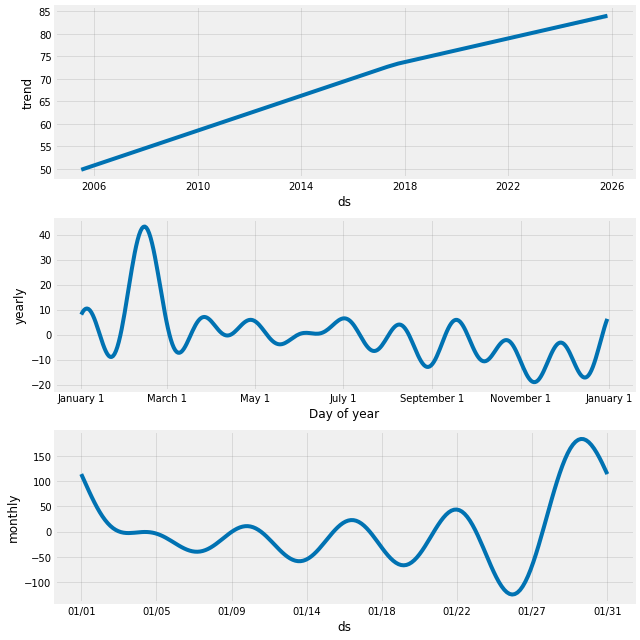

In [35]:
model = Prophet(weekly_seasonality=False)# the Prophet class (model)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5) # Adding seasonality as monthly, because we require the monthly prediction  
forecast = model.fit(df).predict(future)# fit the model using all data and predicting future
# Let's plot the components of our model
model.plot_components(forecast);

In [36]:
# Let's see the components of our model
model.component_modes

{'additive': ['monthly',
  'yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [37]:
# Future dates
future

,ds
0,2005-07-01
1,2005-08-01
2,2005-09-01
3,2005-10-01
4,2005-11-01
...,...
240,2025-07-01
241,2025-08-01
242,2025-09-01
243,2025-10-01


Now, we've to predict the closing price for the future dates.

In [38]:
### Prediction on future data
prediction=model.predict(future)

In [39]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-07-01,49.831499,-57.095431,93.300861,49.831499,49.831499,-31.982298,-31.982298,-31.982298,-38.463627,-38.463627,-38.463627,6.481329,6.481329,6.481329,0.0,0.0,0.0,17.849201
1,2005-08-01,49.995517,-52.076775,90.996286,49.995517,49.995517,-32.134399,-32.134399,-32.134399,-31.377087,-31.377087,-31.377087,-0.757312,-0.757312,-0.757312,0.0,0.0,0.0,17.861119
2,2005-09-01,50.159536,-49.798058,96.329525,50.159536,50.159536,-31.143799,-31.143799,-31.143799,-19.441884,-19.441884,-19.441884,-11.701915,-11.701915,-11.701915,0.0,0.0,0.0,19.015736
3,2005-10-01,50.318263,-64.022776,84.222199,50.318263,50.318263,-38.755794,-38.755794,-38.755794,-31.377087,-31.377087,-31.377087,-7.378707,-7.378707,-7.378707,0.0,0.0,0.0,11.562470
4,2005-11-01,50.482282,-53.335568,91.408805,50.482282,50.482282,-30.069317,-30.069317,-30.069317,-19.441884,-19.441884,-19.441884,-10.627433,-10.627433,-10.627433,0.0,0.0,0.0,20.412965


In [40]:
# here yhat value is just the mean of yhat_lower and yhat_upper

(-59.029943 +	96.396855)/2

18.683456

as we can see the yhat value are approximately equal

In [41]:
prediction[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2005-07-01,17.849201,-57.095431,93.300861
1,2005-08-01,17.861119,-52.076775,90.996286
2,2005-09-01,19.015736,-49.798058,96.329525
3,2005-10-01,11.562470,-64.022776,84.222199
4,2005-11-01,20.412965,-53.335568,91.408805


In [42]:
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
240,2025-07-01,113.635043,39.515899,182.687648
241,2025-08-01,74.930744,-0.260443,156.147529
242,2025-09-01,24.849136,-52.596412,93.374775
243,2025-10-01,68.528607,-5.981870,139.294513
244,2025-11-01,26.142876,-49.446367,99.674353


Now, we plot the forecast by calling the **Prophet.plot** method and passing in our forecast dataframe.

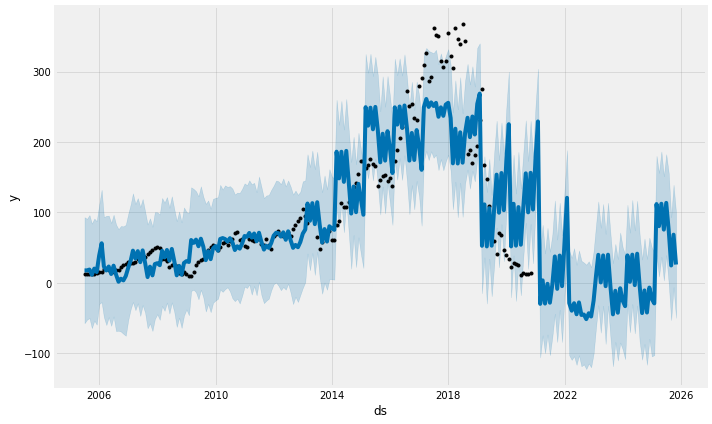

In [43]:
#### plot the predicted projection
model.plot(prediction);

From above plot we can see that there is increase in trend in the year 2024 and 2025 onwards.

We can also see the trend, yearly seasonality, and weekly seasonality of the time series. By using the **Prophet.plot_components** method.

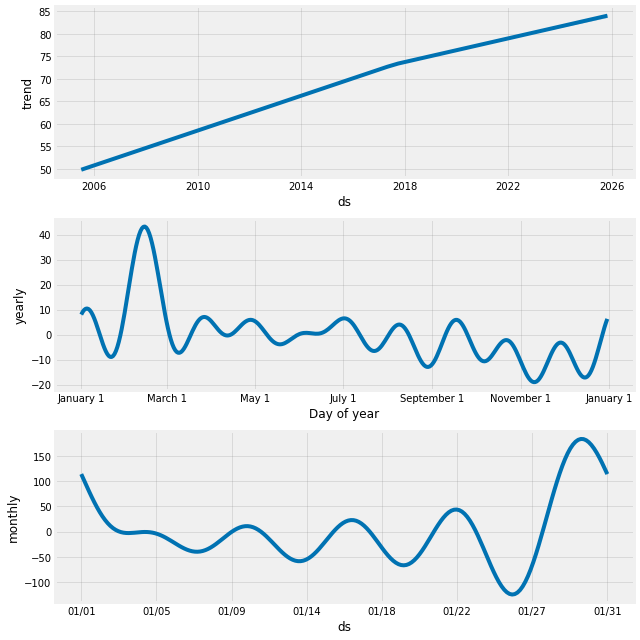

In [44]:
## Visualize Each Components[Trends,Weekly]
model.plot_components(prediction);

**Trends:**

* YES BANK's stock price is showing signs of upper trend yearly.
* YES BANK's stock price show upper trend signs during February  and on December month it tend to give low stock price.
* YES BANK's stock price is showing signs of upper trend during end of the month.

# **Cross Validation**
Next let’s measure the forecast error using the historical data. We’ll do this by comparing the predicted values with the actual values.

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In order to perform this operation we select cut of points in the history of the data and fit the model with data upto that cut off point. Afterwards we compare the actual values to the predicted values. The cross_validation method allows us to do this in Prophet. This method take the following parameters as explained below:

*  horizon the forecast horizon
*  initial the size of the initial training period
*  period the spacing between cutoff dates

In [45]:
df.shape

(185, 2)

In [46]:
from fbprophet.diagnostics import cross_validation

**Cross-Validation for time series:**

Computes forecasts from historical cutoff points, which user can input.
If not provided, begins from (end - horizon) and works backwards, making
cutoffs with a spacing of period until initial is reached.



**Parameters used:**

*  model: Prophet class object. Fitted Prophet model.
*  horizon: string with pd.Timedelta compatible style, e.g., '5 days',
    '3 hours', '10 seconds'.
*  period(spacing between cutoff dates) : string with pd.Timedelta compatible style. Simulated forecast will
    be done at every this period. If not provided, 0.5 * horizon is used.
*  initial( the size of the initial training period) : string with pd.Timedelta compatible style. The first training
    period will include at least this much data. If not provided,
3 * horizon is used.

Here, the output of **cross_validation** is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

In [47]:
df_cv=cross_validation(model,horizon="365 days",period='180 days',initial='1095 days')

INFO:fbprophet:Making 24 forecasts with cutoffs between 2008-07-02 00:00:00 and 2019-11-02 00:00:00


In [48]:
df_cv.shape

(288, 6)

In [49]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-08-01,40.245191,38.978244,41.507233,26.83,2008-07-02
1,2008-09-01,41.067000,39.952921,42.342719,24.13,2008-07-02
2,2008-10-01,40.789432,39.545481,42.080711,13.58,2008-07-02
3,2008-11-01,42.973994,41.704778,44.207500,12.26,2008-07-02
4,2008-12-01,40.762470,39.455613,41.994403,15.03,2008-07-02


In [50]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
283,2020-07-01,129.299625,67.569147,191.195750,11.95,2019-11-02
284,2020-08-01,182.016747,120.760064,243.352157,14.37,2019-11-02
285,2020-09-01,224.775941,162.174288,279.545453,13.15,2019-11-02
286,2020-10-01,174.543406,111.844226,233.188612,12.42,2019-11-02
287,2020-11-01,225.362603,164.954387,286.532190,14.67,2019-11-02


# **Obtaining the Evaluation Metrics:**


We use the performance_metrics utility to compute the Mean Squared Error(MSE), Root Mean Squared Error(RMSE),Mean Absolute Error(MAE), Mean Absolute Percentage Error(MAPE) and the coverage of the the yhat_lower and yhat_upper estimates.

In [51]:
from fbprophet.diagnostics import performance_metrics
df_performance=performance_metrics(df_cv)
df_performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,35 days,2909.646693,53.941141,32.995170,0.445647,0.209830,0.428571
1,39 days,2827.846854,53.177503,31.325250,0.381288,0.154778,0.464286
2,40 days,2823.260689,53.134364,31.181460,0.369197,0.154778,0.464286
3,41 days,3005.183478,54.819554,33.352355,0.377365,0.183549,0.428571
4,44 days,3002.675408,54.796673,33.301062,0.380515,0.207394,0.410714


In [52]:
from fbprophet.plot import plot_cross_validation_metric

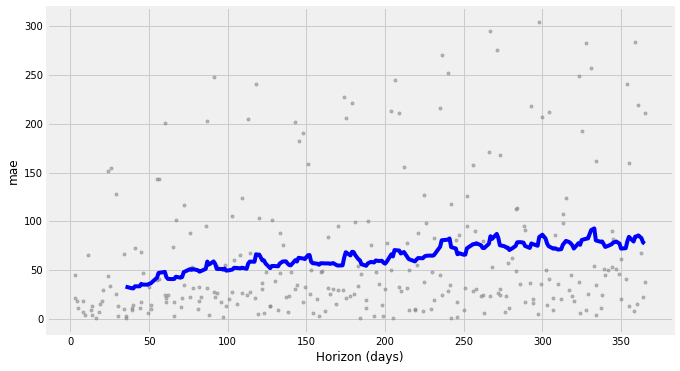

In [53]:
fig=plot_cross_validation_metric(df_cv,metric='mae')

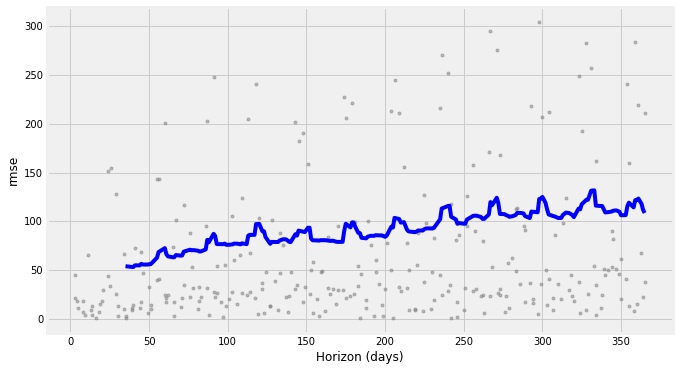

In [54]:
fig=plot_cross_validation_metric(df_cv,metric='rmse')

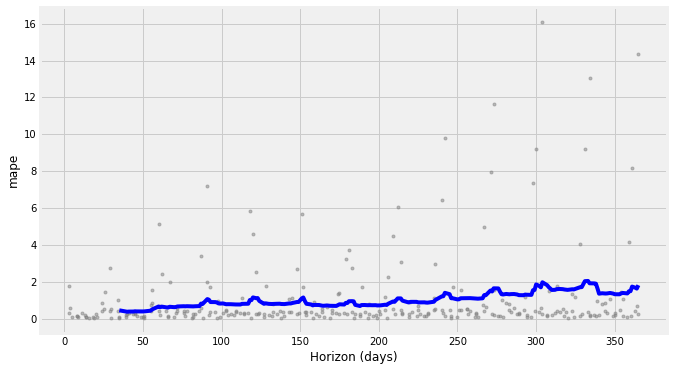

In [55]:
fig=plot_cross_validation_metric(df_cv,metric='mape')

Here as shown for **MAPE**(Mean Absolute Percentage Error). **Dots show** the absolute percent error for each prediction in df_cv. The **blue line** shows the MAPE, where the mean is taken over a rolling window of the dots.

We see for this forecast that errors around **3%** are typical for predictions one month into the future, and that errors increase up to around **18-19%** for predictions that are a year out.

# **Conclusion:**

* Fbprophet is the best performing time series model in terms of accuracy.
* There is increase in trend of Yes Bank stock price in the year 2018 onwards.
* February is the months where there is more upward trends for the stock. 
* July also shows the upward trend but not as much February.
* November and December are months with the most downward pressure.
* On yearly basis there is increase in trend from 2024 onwards.

